```
         Copyright Rein Halbersma 2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 2 Multi-armed Bandits

In [1]:
import gym
import numpy as np
import pandas as pd
import plotnine as p9

from doctrina.algorithms import mc

**Exercise 2.1**: *In $\varepsilon$-greedy action selection, for the case of two actions and $\varepsilon$ = 0.5, what is the probability that the greedy action is selected?*

In [2]:
def epsilon_greedy(k, epsilon):
    policy = np.full(k, epsilon / k)
    policy[0] += 1 - epsilon
    return policy

print(epsilon_greedy(2, 0.5)[0])

0.75


## 2.3 The 10-armed Testbed

In [3]:
k = 10
mu, sigma = 0, 1
s = 1
steps = 1_000
runs = 2_000
bandits = np.array([
    gym.make('Bandit-v0', k=k, mu=mu, sigma=sigma, s=s, steps=steps) 
    for _ in range(runs)
])
epsilon_chr = chr(949)

In [4]:
epsilons = [ 0, .01, .1 ]
a_hist, R_hist = tuple(
    list(t)
    for t in zip(*[
        mc.Q_policy_iter_bandit_eps(bandits, steps, epsilon)
        for epsilon in epsilons
    ])
)

100%|██████████| 2000/2000 [00:45<00:00, 44.02it/s]


In [5]:
legend = [ f'{epsilon_chr}={eps}' for eps in epsilons ]
legend[0] += ' (greedy)'

In [6]:
df_R = pd.concat([
    mc.reward_history(R, i, legend[i])
    for i, R in enumerate(R_hist)
])

In [7]:
df_a = pd.concat([
    mc.action_history(a, i, legend[i])
    for i, a in enumerate(a_hist)
])

In [8]:
fig_2_2_upper = (
    p9.ggplot(df_R, p9.aes(y='reward', x='steps')) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('Average\nreward') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

In [9]:
fig_2_2_lower = (
    p9.ggplot(df_a.query('arm == 0'), p9.aes(y='selected', x='steps')) + p9.ylim(0, 1) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('%\nOptimal\naction') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

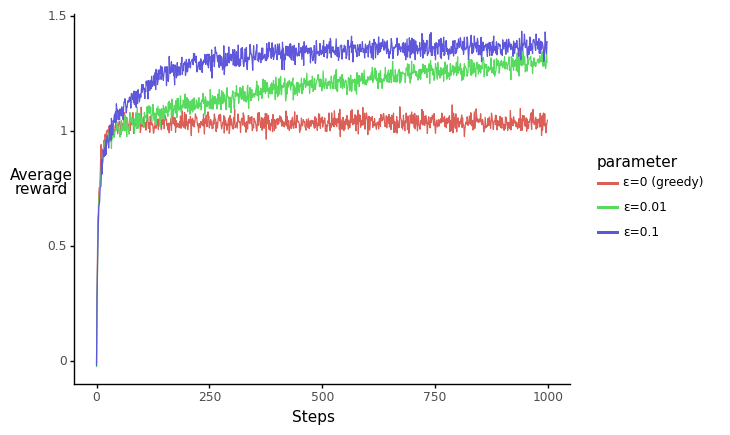

<ggplot: (8790430363742)>


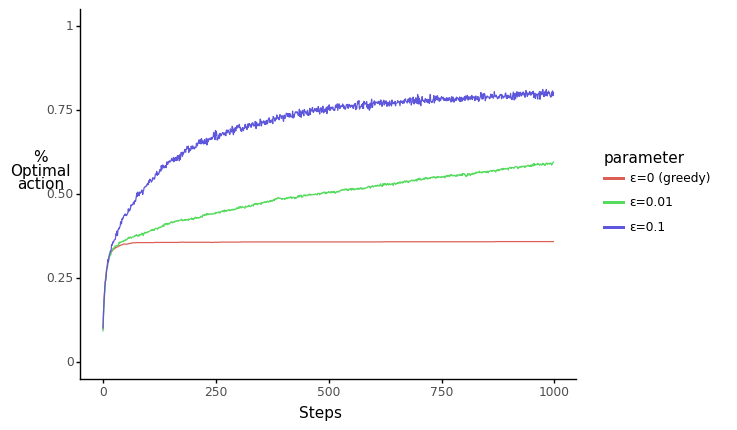

<ggplot: (8790430343708)>


In [10]:
print(fig_2_2_upper)
print(fig_2_2_lower)

**Figure 2.2**: *Average performance of $\varepsilon$-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.*

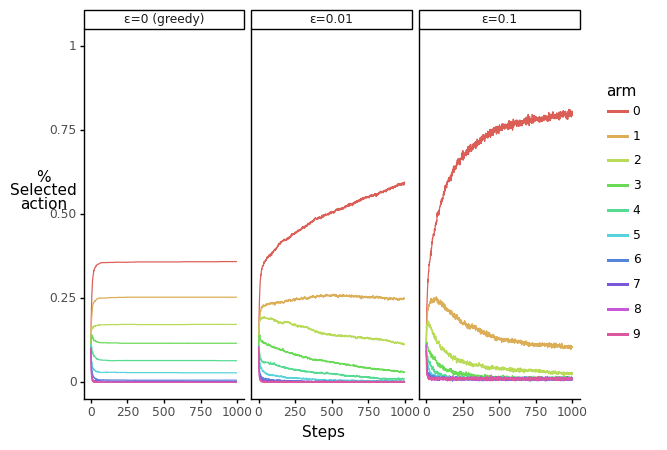

<ggplot: (8790430320848)>

In [11]:
(
    p9.ggplot(df_a, p9.aes(y='selected', x='steps')) + p9.ylim(0, 1) +
    p9.geom_line(p9.aes(color='arm')) +
    p9.facet_grid('. ~ parameter') +
    p9.ylab('%\nSelected\naction') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

**Exercise 2.2: Bandit example** *Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit  algorithm using $\varepsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of Q1(a) = 0, for all a. Suppose the initial sequence of actions and rewards is A1 = 1, R1 = −1, A2 = 2, R2 = 1, A3 = 2, R3 = −2, A4 = 2, R4 = 2, A5 = 3, R5 = 0. On some of these time steps the $\varepsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?*

Exploration could have occurred on any time step, since any action can be selected at any time with an $\varepsilon$-greedy strategy. Exploration had to have occured on time steps where one of the best actions so far wasn't selected. This happened on time steps 4 and 5. On time step 4, action 2 had a Q-value of -0.5 at that point (the average of its returns of +1 and -2 on times steps 2 and 3), whereas all previously non-selected actions still their initial Q-values of zero. On time step 5, the selected action 3 still had its initial Q-value of zero, whereas action 2 had a Q-value of +0.33 (the average of its returns of +1, -2 and +2).

**Exercise 2.3**: *In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.*

In [12]:
print(np.bincount(a_hist[0][:, -1], minlength=k)[0] / runs)
print(epsilon_greedy(k, .01)[0])
print(epsilon_greedy(k, .1)[0])

0.359
0.991
0.91


In [13]:
from scipy.stats import norm

def normal_order_statistic(r, n):
    a = 3 / 8
    return norm.ppf((r + 1 - a) / (n + 1 - 2 * a))

order_statistics = np.array([
    normal_order_statistic(r, k) 
    for r in reversed(range(k))
])

values = np.vstack([env.q_star for env in bandits])
print(values.mean(axis=0))
print(order_statistics)

[ 1.54036804  0.99817833  0.65677784  0.36683874  0.11649353 -0.13198593
 -0.38164517 -0.65793014 -0.99945955 -1.53293294]
[ 1.54663527  1.00049055  0.65542351  0.37546177  0.12258084 -0.12258084
 -0.37546177 -0.65542351 -1.00049055 -1.54663527]


In [14]:
print(order_statistics @ np.bincount(a_hist[0][:, -1], minlength=k) / runs)
print(order_statistics @ epsilon_greedy(k, .01))
print(order_statistics @ epsilon_greedy(k, .1))

0.9655018714697668
1.5311689186852375
1.3919717442593071


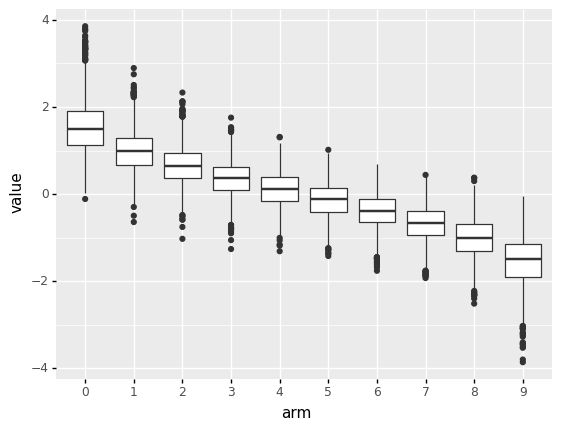

<ggplot: (8790426535699)>

In [15]:
df = (pd
    .DataFrame(values)
    .rename_axis('env')
    .reset_index()
    .melt(id_vars='env', var_name='arm')
)
p9.ggplot(df, p9.aes(y='value', x='arm')) + p9.geom_boxplot()

## 2.5 Tracking a Nonstationary Problem

## 2.6 Optimistic Initial Values

In [16]:
a_hist, R_hist = tuple(
    list(t)
    for t in zip(*[
        mc.Q_policy_iter_bandit_eps(bandits, steps, epsilon=0.0, Q0=5, alpha=0.1),
        mc.Q_policy_iter_bandit_eps(bandits, steps, epsilon=0.1, Q0=0, alpha=0.1)
    ])
)

100%|██████████| 2000/2000 [00:39<00:00, 50.61it/s]


In [17]:
legend = [
    f'Q1=5, {epsilon_chr}=0.0',
    f'Q1=0, {epsilon_chr}=0.1'
]

In [18]:
df_R = pd.concat([
    mc.reward_history(R, i, legend[i])
    for i, R in enumerate(R_hist)
])

In [19]:
df_a = pd.concat([
    mc.action_history(a, i, legend[i])
    for i, a in enumerate(a_hist)
])

In [20]:
fig_2_3_upper = (
    p9.ggplot(df_R, p9.aes(y='reward', x='steps')) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('Average\nreward') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

In [21]:
fig_2_3_lower = (
    p9.ggplot(df_a.query('arm == 0'), p9.aes(y='selected', x='steps')) + p9.ylim(0, 1) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('%\nOptimal\naction') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

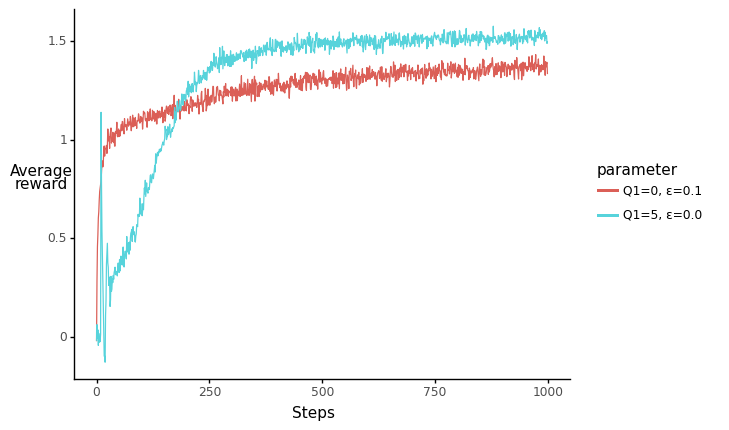

<ggplot: (8790426540201)>


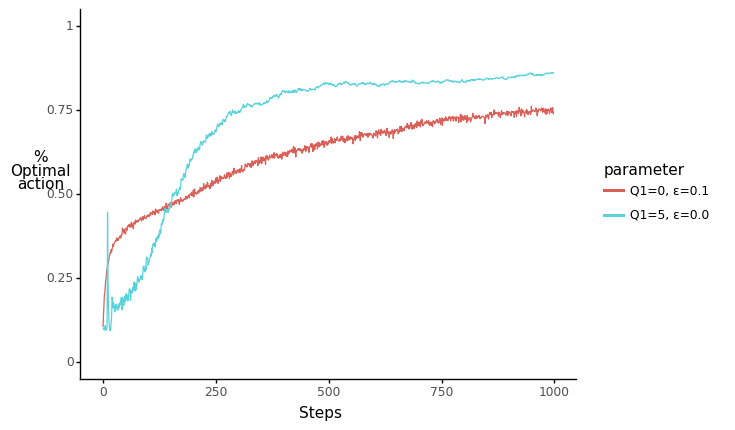

<ggplot: (8790426538367)>


In [22]:
print(fig_2_3_upper)
print(fig_2_3_lower)

**Figure 2.3**: *The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods used a constant step-size parameter, $\alpha$ = 0.1.*

## 2.7 Upper-Confidence-Bound Action Selection

In [23]:
a_hist, R_hist = tuple(
    list(t)
    for t in zip(*[
        mc.Q_policy_iter_bandit_eps(bandits, steps, epsilon=.1),
        mc.Q_policy_iter_bandit_ucb(bandits, steps, c=2)
    ])
)

100%|██████████| 2000/2000 [01:00<00:00, 33.09it/s]


In [24]:
legend = [
    f'{epsilon_chr}-greedy {epsilon_chr}=0.1',
    f'UCB c=2'
]

In [25]:
df_R = pd.concat([
    mc.reward_history(R, i, legend[i])
    for i, R in enumerate(R_hist)
])

In [26]:
df_a = pd.concat([
    mc.action_history(a, i, legend[i])
    for i, a in enumerate(a_hist)
])

In [27]:
fig_2_4_upper = (
    p9.ggplot(df_R, p9.aes(y='reward', x='steps')) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('Average\nreward') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

In [28]:
fig_2_4_lower = (
    p9.ggplot(df_a.query('arm == 0'), p9.aes(y='selected', x='steps')) + p9.ylim(0, 1) +
    p9.geom_line(p9.aes(color='parameter')) +
    p9.ylab('%\nOptimal\naction') + p9.xlab('Steps') +
    p9.theme_classic() + p9.theme(axis_title_y=p9.element_text(angle=0))
)

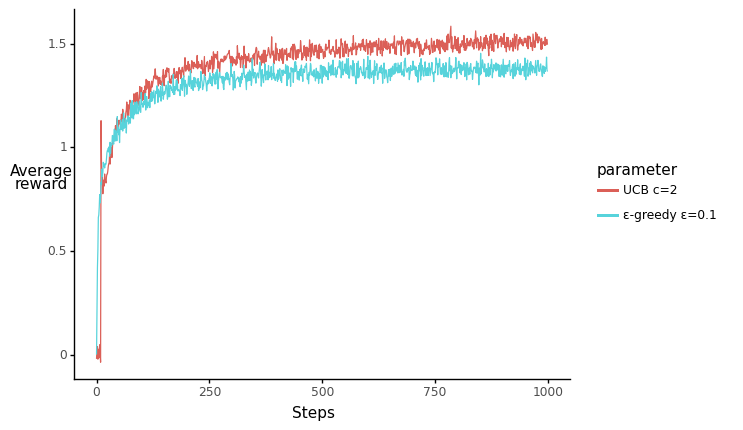

<ggplot: (8790415331238)>


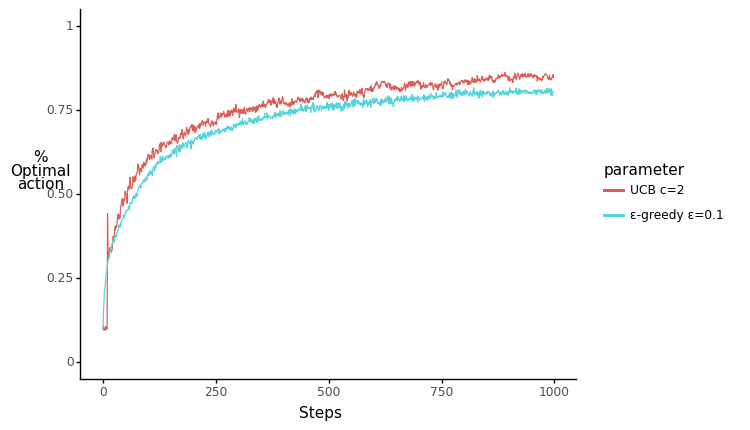

<ggplot: (8790426613703)>


In [29]:
print(fig_2_4_upper)
print(fig_2_4_lower)

**Figure 2.4** *Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than $\varepsilon$-greedy action selection, except in the first k steps, when it selects randomly among the as-yet-untried actions.*

## 2.8 Gradient Bandit Algorithms